# Runge Cutter with Embedded Error Estimate using Dormand Prince

Here is the equation that we need to solve in order to test our method:

\begin{equation}
\dot{u_0}= u_1 k (1-u_0^2)
\end{equation}
\begin{equation}
\dot{u_1}= u_1 -u_0
\end{equation}

I used RK Dormand Prince with variable stepsizes. 

Because this is a nonlinear equation, I realized I needed to choose the initial conditions carfully, otherwise I could be found in a weird attractor. This is why at some point I plotted the phase portrait of that equation to find out that between -1 and 1, there was an unstable fixed point and that -1 and 1 seemed to be some sort of nullclines. This is the reason why I chose the initial conditions that I used.

<img src="img.png" alt="Drawing" style="width: 400px;"/>>

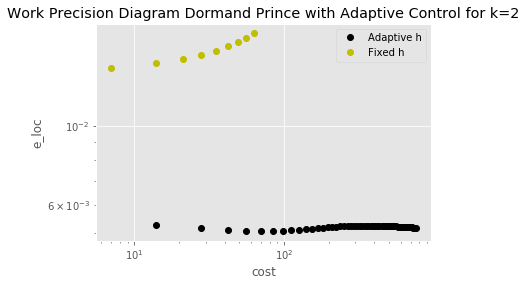

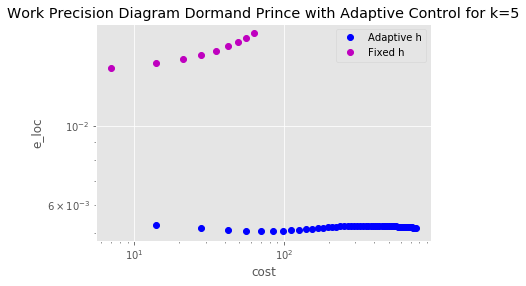

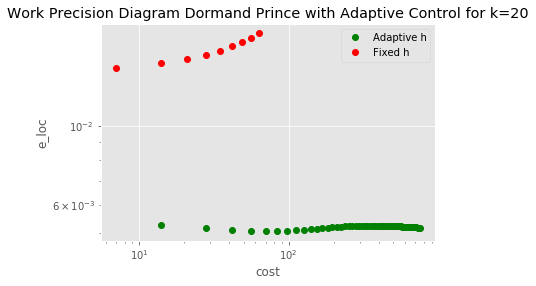

In [243]:
import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')

def RK_DP(f, u0,aTol,k,cost1, sF, tfinal=1, h=.1):
    #I am using the Dormand Prince method. Here is the Runge Cutter's butcher table:
    A= numpy.array([[0., 0.,0.,0.,0.,0.,0.],
        [1./5., 0.,0.,0.,0.,0.,0.],
        [3./40., 9./40.,0.,0.,0.,0.,0.],
        [44./45., -56./15., 32/9,0,0,0,0],
        [19372/6561, 25360/2187, 64448/6561, -212./729,0,0,0],
        [9017/3168, -355/33, 46732/5247, 49/176, -5103/18656,0,0],
        [35/384, 0, 500/1113, 125/192, -2187/6784, 11/84,0]])
    b= numpy.array([[35/384, 0, 500/1113, 125/192, -2187/6784, 11/84,0],
                 [5179/57600, 0, 7571/16695, 393/640,-92097/339200,187/2100,1/40]]) 
    e_loc=10000;
    p=5; #The completion formula is 5th order accurate, according to wikipedia 
    c = numpy.sum(A, axis=1)
    s = len(c)
    u = u0.copy()
    t = 0.
    hist = [(t, u0, e_loc, cost1)]
    while t < tfinal:
        if tfinal - t < 1.01*h:
            h = tfinal - t
            tnext = tfinal
        else:
           # print(h)
            tnext = t + h
        h = min(h, tfinal - t)
        fY = numpy.zeros((len(u0), s))
        for i in range(s):
            Yi = u.copy()
            for j in range(i):
                Yi += h * A[i,j] * fY[:,j]
            fY[:,i] = f(t + h*c[i], Yi,k)
            cost1=cost1+1. # To count the number of rhs function evaluation. I know this is not very sophisticated.
        u += h * fY.dot(b[0,:])
                 
        e_loc= numpy.linalg.norm(h*(b[0,:]-b[1,:]).T*fY, numpy.inf)
        if e_loc > aTol:
            #I did not add the line t=tnext here because I am rejecting the step
            h= sF*h*(aTol/e_loc)**(1/p)              
        else:
            h= 2.0*h #I double the timestep when it is not rejected as suggested in Numerical Recipes in C++.
            t = tnext
            hist.append((t, u.copy(), e_loc.copy(), cost1))
    return hist

def RK_DP_const(f, u0,k,cost2, tfinal=1, h=.1):
    #I am using the Dormand Prince method. Here is the Runge Cutter's butcher table:
    A= numpy.array([[0, 0,0,0,0,0,0],
        [1./5., 0,0,0,0,0,0],
        [3./40., 9./40.,0,0,0,0,0],
        [44/45, -56/15, 32/9,0,0,0,0],
        [19372/6561, 25360/2187, 64448/6561, -212./729,0,0,0],
        [9017/3168, -355/33, 46732/5247, 49/176, -5103/18656,0,0],
        [35/384, 0, 500/1113, 125/192, -2187/6784, 11/84,0]])
    b= numpy.array([[35/384, 0, 500/1113, 125/192, -2187/6784, 11/84,0], #5th order accurate
                 [5179/57600, 0, 7571/16695, 393/640,-92097/339200,187/2100,1/40]]) #4th order accurate   
    c = numpy.sum(A, axis=1)
    s = len(c)
    u = u0.copy()
    t = 0.
    hist = [(t, u0, cost2)]
    while t < tfinal:
        if tfinal - t < 1.01*h:
            h = tfinal - t
            tnext = tfinal
        else:
            tnext = t + h
        h = min(h, tfinal - t)
        fY = numpy.zeros((len(u0), s))
        for i in range(s):
            Yi = u.copy()
            for j in range(i):
                Yi += h * A[i,j] * fY[:,j]
            fY[:,i] = f(t + h*c[i], Yi,k)
            cost2=cost2+1.; 
        u += h * fY.dot(b[0,:]) 
        e_loc= numpy.linalg.norm(h*(b[0,:]-b[1,:]).T*fY, numpy.inf) #Local error shown in class. I am only using one Tol
        t=tnext
        hist.append((t, u.copy(), e_loc.copy(), cost2))
    return hist

                        
def u_dot(t,u,k):
    a = numpy.array([[u[1]*k*(1-u[0]**2)], [u[1]-u[0]]])
    return a.reshape(2,)

#Initializing the counters that will tell me the number of function evaluations
cost1= 0. 
cost2= 0.
aTol=1e-2 #This tolerance gave me faster results                   
k_=[2.,5.,20.]
colors = ['ko','bo','go']
colors1 = ['yo','mo','ro']
u0= numpy.array([1.,1.5]) #This point will guarantee that my solutions will not go crazy because we are at a stable line

c = 0
for k in k_:
    pyplot.figure()
    hist=RK_DP(u_dot, u0, aTol,k,cost1, sF=0.5, tfinal=1., h=0.1)
    hist1= RK_DP_const(u_dot, u0,k,cost2, tfinal=1, h=.1)
    times = [i[0] for i in hist[1:]]
    u = [i[1][0] for i in hist[1:]]
    e_loc = [i[2] for i in hist[1:-1]]
    costs = [i[3] for i in hist[1:-1]]
    times1 = [i[0] for i in hist1[1:]]
    u1 = [i[1][0] for i in hist1[1:]]
    e_loc1 = [i[2] for i in hist1[1:-1]]
    costs1 = [i[3] for i in hist1[1:-1]]
    pyplot.loglog(costs,e_loc, colors[c],label='Adaptive h')
    pyplot.loglog(costs1,e_loc1, colors1[c],label='Fixed h')
    pyplot.xlabel('cost')
    pyplot.ylabel('e_loc')
    pyplot.legend(loc='upper right')
    pyplot.title('Work Precision Diagram Dormand Prince with Adaptive Control for k=%d'%k)
    pyplot.show()
    c = c + 1
